# Data tutorial - CESM HR regridded 

* Notebook creator: Jinbo Wang
* Data creator: Jaison Karin
* CESM_HR project: Ping Chang et al.

This note book is written to be run on AWS cloud environment hosted by hub.openveda.cloud or similar platforms such as those maintained by 2i2c. 

05/18/2025

## Load and examine data directly from S3

The s3fs module, provided by AWS, allows Python to interact with S3 as if it were a local filesystem. It’s essential for reading files (like NetCDF) from S3 buckets. Below is a complete example demonstrating the specific operations needed to use s3fs to load a NetCDF file, with Dask for lazy loading and an option to convert to Zarr.

In [ ]:
import s3fs
import xarray as xr
import pylab as plt
import numpy as np

# Initialize S3 filesystem
s3 = s3fs.S3FileSystem(anon=False, profile='default') #read only access
s3_path = "s3://odsl/cesm_hr_1x1/*nc"

# Open dataset with Dask chunking
file_names = s3.glob(s3_path)
display(file_names)

## Load data using xarray 

In [3]:
nc_data=xr.open_dataset(s3.open(file_names[7],mode='rb'), engine='h5netcdf', chunks={'time': 120})
nc_data

<xarray.Dataset> Size: 9GB
Dimensions:  (time: 36500, y_regr: 169, x_regr: 360)
Coordinates:
  * time     (time) object 292kB 2001-01-01 12:00:00 ... 2100-12-31 12:00:00
Dimensions without coordinates: y_regr, x_regr
Data variables:
    LON      (y_regr, x_regr) float64 487kB dask.array<chunksize=(169, 360), meta=np.ndarray>
    LAT      (y_regr, x_regr) float64 487kB dask.array<chunksize=(169, 360), meta=np.ndarray>
    MASK     (y_regr, x_regr) float32 243kB dask.array<chunksize=(169, 360), meta=np.ndarray>
    SSH      (time, y_regr, x_regr) float32 9GB dask.array<chunksize=(120, 169, 360), meta=np.ndarray>
Attributes:
    out_file:  /ihesp/user/jaisonk/WORK/Models/CESM/regrid/HR_E03/tseries/ocn...
    computer:  c262
    pwd:       /scratch/user/jaisonk/SOFTWARE/ESMF/cesm_regrid_01
    date:      May/04/2025  2:50:53 AM

## Example: Perform 1-yr mean at the surface 

In [3]:
ssh=nc_data.SSH[:12,...].mean(dim='time') # Computation is not yet done at this step as the file was openned with Dask (chunks)

In [4]:
ssh_1ymean=ssh.compute() 

<xarray.DataArray 'SSH' (y_regr: 20)> Size: 80B
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, -1.7599005,
       -1.8006325, -1.68404  , -1.4865316, -1.5089265, -1.2052144],
      dtype=float32)
Dimensions without coordinates: y_regr


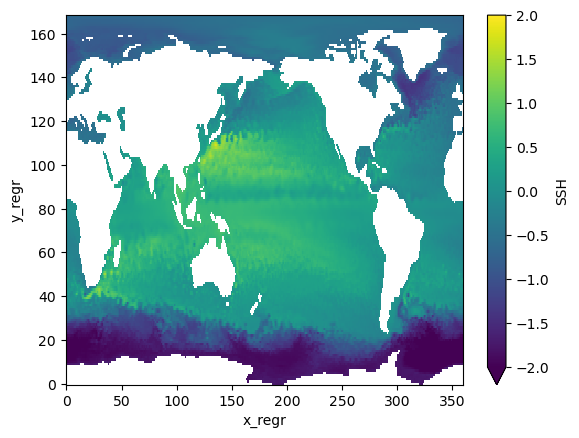

In [5]:
ssh_1ymean.plot(vmin=-2,vmax=2)
print(ssh_1ymean[:20,100]) #Show that the missing values are filled with nan.

## Example: global mean Sea Surface height over the 100 years

This is an illustration of the computation. 

In [5]:
# Extract variables
dd = nc_data.SSH  # Shape: (t, y, x)
lon = nc_data.LON    # Shape: (y, x)
lat = nc_data.LAT    # Shape: (y, x)

# Earth's radius in meters
R = 6371000

# Convert lat and lon to radians
lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)

# Compute differences in latitude and longitude (in radians)
dlat = xr.DataArray(
        np.abs(np.diff(lat_rad, axis=0, prepend=lat_rad[0:1, :])),
        dims=['y_regr', 'x_regr'],
        coords=lat.coords
    ).interp(y_regr=lat.y_regr, method='nearest')  # Interpolate to original y dimension

dlon = xr.DataArray(
        np.abs(np.diff(lon_rad, axis=1, prepend=lon_rad[:, 0:1])),
        dims=['y_regr', 'x_regr'],
        coords=lon.coords
    ).interp(x_regr=lon.x_regr, method='nearest')  # Interpolate to original x dimension
        
# Compute grid cell area: A = R^2 * cos(lat) * Δlat * Δlon
# Use mean latitude for cos(lat) to align shapes
cos_lat = np.cos(lat_rad)
area = (R ** 2) * cos_lat * dlat * dlon

# Ensure area and salt have compatible shapes
# Trim area to match salt's shape if needed (due to diff reducing dimensions)

area = area.where(dd[0,...].notnull(), 0)  # Mask areas where salt is NaN (e.g., land), assume dd is on (time,lat,lon)

# Compute area-weighted salinity
weighted = dd * area

# Calculate global mean: sum(weighted_salt) / sum(area)
global_mean = weighted[::12,:,:].sum(dim=['y_regr', 'x_regr']) / area.sum(dim=['y_regr', 'x_regr'])
print(global_mean.shape)

(3042,)


In [ ]:
plt.plot(global_mean)